# Limb Vector (Zawada et. al. 2021) Comparisons

Runs the comparisons found in 

Zawada, D., Franssens, G., Loughman, R., Mikkonen, A., Rozanov, A., Emde, C., Bourassa, A., Dueck, S., Lindqvist, H., Ramon, D., Rozanov, V., Dekemper, E., Kyrölä, E., Burrows, J. P., Fussen, D., and Degenstein, D.: Systematic comparison of vectorial spherical radiative transfer models in limb scattering geometry, Atmos. Meas. Tech., 14, 3953–3972, https://doi.org/10.5194/amt-14-3953-2021, 2021.

The input data and output data for this comparison is downloaded automatically from the zenodo reference at https://zenodo.org/records/4292303.

In [1]:
import sasktran2 as sk
import appdirs
from pathlib import Path
import shlex
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


def rtm_comparison_file():
    data_dir = Path(appdirs.user_data_dir('sasktran2'))

    if not data_dir.exists():
        data_dir.mkdir(parents=True)

    file = data_dir.joinpath('zawada_AMT_rtm_comparison_data_v1.nc')

    if not file.exists():
        from zenodo_get import zenodo_get
        zenodo_get(shlex.split('--record 4292303 -o "{}"'.format(data_dir.as_posix())))

    return file

In [2]:
def load_scenario(geometry_index: int, atmosphere_index: int, albedo_index: int, test_case: int,
                  altitude_spacing: float=500):
    rtm_file = rtm_comparison_file()

    geo = xr.open_dataset(rtm_file, group='geometry_data')
    anc = xr.open_dataset(rtm_file, group='ancillary_data')
    model = xr.open_dataset(rtm_file, group='model_data')

    albedo = float(model['albedo'].isel(albedo=albedo_index))
    albedo = np.ones(len(model['wavelength'])) * albedo

    geo = geo.isel(solar_condition=geometry_index)

    anc = anc.interp(altitude=np.arange(0, 100001, altitude_spacing))

    model = model.isel(solar=geometry_index, composition=atmosphere_index, albedo=albedo_index, test_case=test_case)

    model_geo = sk.Geometry1D(np.cos(float(geo.tangent_sza) * np.pi/180), 0.0, 6371000, anc.altitude.values.astype(float), sk.InterpolationMethod.LinearInterpolation,
                              sk.GeometryType.Spherical)


    viewing_geo = sk.ViewingGeometry()

    for alt in geo.tangent_altitude.values:
        viewing_geo.add_ray(sk.TangentAltitudeSolar(alt*1000, float(geo.tangent_saa)*np.pi/180, 200000, np.cos(float(geo.tangent_sza) * np.pi/180)))

    config = sk.Config()
    config.num_stokes = 3

    wavelengths_nm = anc.wavelength.values

    # Add Rayleigh
    atmo = sk.Atmosphere(model_geo, config, wavelengths_nm, calculate_derivatives=False)
    atmo.pressure_pa = anc.pressure.values
    atmo.temperature_k = anc.temperature.values

    model_geo.refractive_index = sk.optical.refraction.ciddor_index_of_refraction(atmo.temperature_k, atmo.pressure_pa, 0.0, 400, 600)

    atmo["brdf"] = sk.constituent.LambertianSurface(albedo)

    atmo["rayleigh"] = sk.constituent.Rayleigh("manual", wavelengths_nm=wavelengths_nm, xs=anc["rayleigh_scattering_cross_section"].values*1e-4, king_factor= np.ones_like(anc["rayleigh_scattering_cross_section"].values))

    if atmosphere_index >= 1:
        # Add ozone
        optical_file = rtm_file.parent / "zawada_AMT_rtm_comparison_data_v1_ozone.nc"

        if not optical_file.exists():
            db = xr.Dataset({"xs": (["wavelength_nm"], anc["ozone_absorption_cross_section"].values*1e-4)},
                            coords={"wavelength_nm": anc.wavelength.values})

            db.to_netcdf(optical_file)

        optical = sk.optical.database.OpticalDatabaseGenericAbsorber(rtm_file.parent / "zawada_AMT_rtm_comparison_data_v1_ozone.nc")

        ozone_vmr = anc.ozone_numden.values / anc.air_numden.values

        atmo["ozone"] = sk.constituent.VMRAltitudeAbsorber(optical, anc.altitude.values.astype(float), ozone_vmr)

    if atmosphere_index == 2:
        # Add aerosol
        aer_numden = anc.aerosol_numden.values

        distribution = sk.mie.distribution.LogNormalDistribution().freeze(median_radius=80, mode_width=1.6)

        aerosol_optical = sk.database.MieDatabase(distribution, sk.mie.refractive.H2SO4(), wavelengths_nm=anc.wavelength.values)

        atmo["aerosol"] = sk.constituent.NumberDensityScatterer(aerosol_optical, anc.altitude.values.astype(float), aer_numden*1e6)

    return {'atmosphere': atmo, 'geometry': model_geo, 'config': config, 'result': model, 'viewinggeo': viewing_geo}


## Test Case 1: Single Scatter

In [3]:
results = []

for geo in range(9):
    scen = load_scenario(geo, 2, 0, 0, 500)
    engine = sk.Engine(scen["config"], scen["geometry"], scen["viewinggeo"])
    radiance = engine.calculate_radiance(scen["atmosphere"])

    scen['result'] = scen['result'].isel(stokes=range(3))
    scen['result']['sasktran2'] = (["wavelength", "altitude", "stokes"], radiance["radiance"].to_numpy())

    results.append(scen['result'])

results = xr.concat(results, dim="geo")


In [4]:
# MMM Differences
# p_diff = (results['sasktran2'] - results['mmm']) / results['mmm'].isel(stokes=0) * 100

# SCIATRAN Differences
p_diff = (results['sasktran2'] - results['radiance'].isel(model=2)) / results['radiance'].isel(stokes=0, model=2) * 100

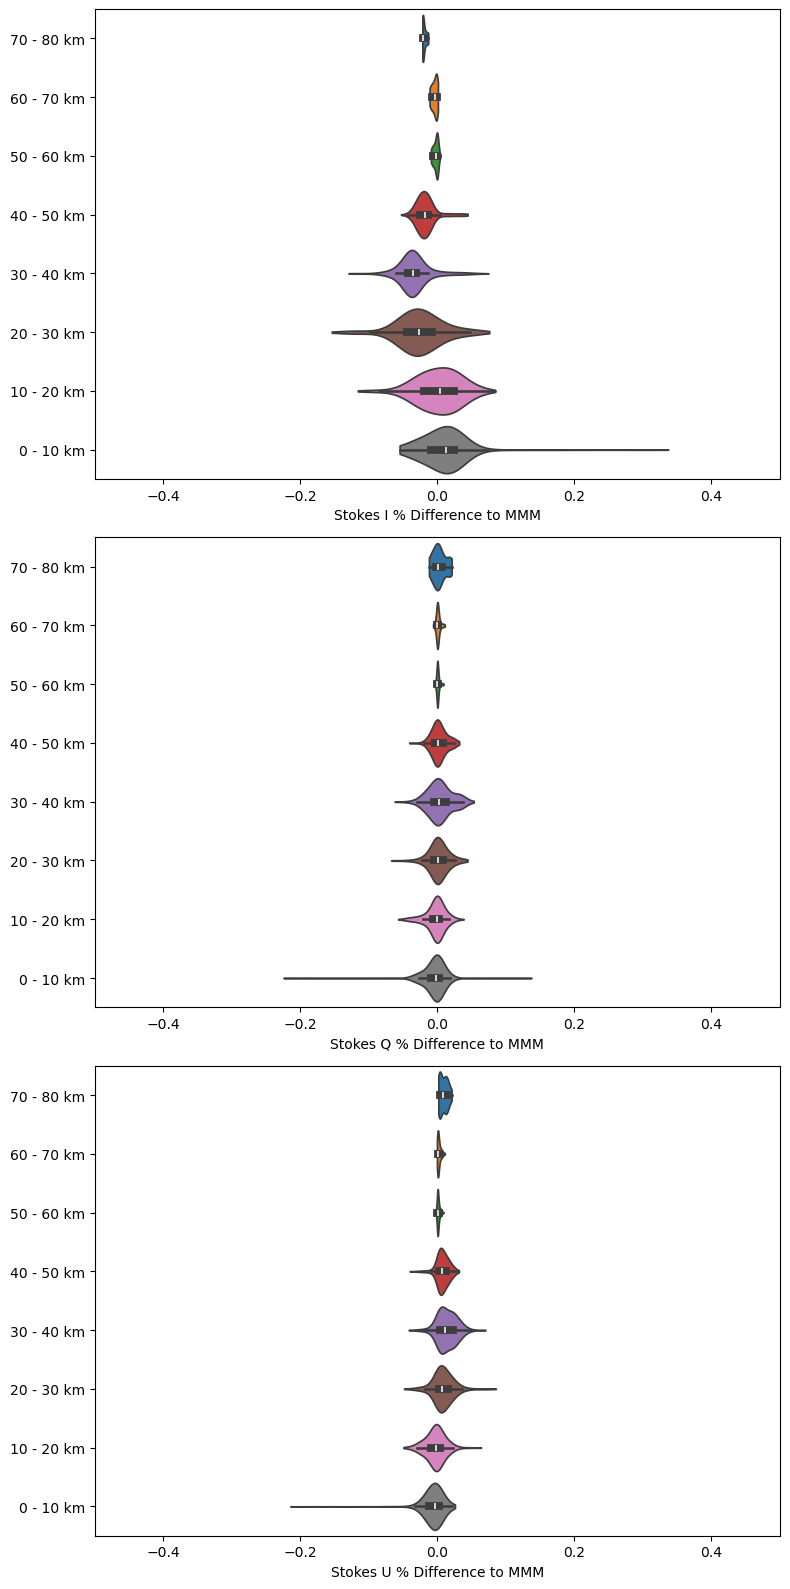

In [5]:
def vioplot(data):
    alt_bins = np.arange(0, 81, 10)

    all_res = []
    cols = []
    for iv, ds in data.stack(z={"geo", "wavelength"}).groupby_bins("altitude", bins=alt_bins):
        all_res.append(ds.values.flatten())

        cols.append(f"{iv.left} - {iv.right} km")

    all_res = np.vstack(all_res).T

    sns.violinplot(pd.DataFrame(all_res[:, ::-1], columns=cols[::-1]), orient="h", bw_adjust=2, cut=0)

plt.figure(figsize=(8, 16))
plt.subplot(3, 1, 1)
vioplot(p_diff.isel(stokes=0))
plt.xlim(-0.5, 0.5)
plt.xlabel('Stokes I % Difference to MMM')

plt.subplot(3, 1, 2)
vioplot(p_diff.isel(stokes=1))
plt.xlim(-0.5, 0.5)
plt.xlabel('Stokes Q % Difference to MMM')
plt.ylabel('')

plt.subplot(3, 1, 3)
vioplot(p_diff.isel(stokes=2))
plt.xlim(-0.5, 0.5)
plt.xlabel('Stokes U % Difference to MMM')
plt.ylabel('')

plt.tight_layout()

## Test Case 2 - Multiple Scatter with Discrete Ordinates Source

## 

In [ ]:
results = []

for geo in range(8, 9):
    scen = load_scenario(geo, 2, 1, 1, 1000)
    scen["config"].multiple_scatter_source = sk.MultipleScatterSource.SuccessiveOrders
    scen["config"].init_successive_orders_with_discrete_ordinates = False
    scen["config"].num_sza = 3
    scen["config"].num_threads = 8
    scen["config"].threading_model = sk.ThreadingModel.Source

    engine = sk.Engine(scen["config"], scen["geometry"], scen["viewinggeo"])

    radiance = engine.calculate_radiance(scen["atmosphere"])

    del engine

    scen['result'] = scen['result'].isel(stokes=range(3))
    scen['result']['sasktran2'] = (["wavelength", "altitude", "stokes"], radiance["radiance"].to_numpy())

    results.append(scen['result'])

results = xr.concat(results, dim="geo")

p_diff = (results['sasktran2'] - results['mmm']) / results['mmm'].isel(stokes=0) * 100

plt.figure(figsize=(8, 16))
plt.subplot(3, 1, 1)
vioplot(p_diff.isel(stokes=0))
plt.xlim(-5, 5)
plt.xlabel('Stokes I % Difference to MMM')

plt.subplot(3, 1, 2)
vioplot(p_diff.isel(stokes=1))
plt.xlim(-5, 5)
plt.xlabel('Stokes Q % Difference to MMM')
plt.ylabel('')

plt.subplot(3, 1, 3)
vioplot(p_diff.isel(stokes=2))
plt.xlim(-5, 5)
plt.xlabel('Stokes U % Difference to MMM')
plt.ylabel('')

plt.tight_layout()

## Test Case 3 - Multiple Scatter with Successive Orders Source and Refraction enabled

In [ ]:
res_refrac = []

for geo in range(0, 1):
    scen = load_scenario(geo, 0, 1, 2, 1000)
    scen["config"].multiple_scatter_source = sk.MultipleScatterSource.SuccessiveOrders
    scen["config"].init_successive_orders_with_discrete_ordinates = False
    scen["config"].num_sza = 5
    scen["config"].num_threads = 8
    scen["config"].los_refraction = True

    engine = sk.Engine(scen["config"], scen["geometry"], scen["viewinggeo"])

    radiance = engine.calculate_radiance(scen["atmosphere"])

    del engine

    scen['result'] = scen['result'].isel(stokes=range(3))
    scen['result']['sasktran2'] = (["wavelength", "altitude", "stokes"], radiance["radiance"].to_numpy())

    res_refrac.append(scen['result'])

res_refrac = xr.concat(res_refrac, dim="geo")

p_diff = (res_refrac['sasktran2'] - res_refrac['mmm']) / res_refrac['mmm'].isel(stokes=0) * 100

plt.figure(figsize=(8, 16))
plt.subplot(3, 1, 1)
vioplot(p_diff.isel(stokes=0))
plt.xlim(-5, 5)
plt.xlabel('Stokes I % Difference to MMM')

plt.subplot(3, 1, 2)
vioplot(p_diff.isel(stokes=1))
plt.xlim(-5, 5)
plt.xlabel('Stokes Q % Difference to MMM')
plt.ylabel('')

plt.subplot(3, 1, 3)
vioplot(p_diff.isel(stokes=2))
plt.xlim(-5, 5)
plt.xlabel('Stokes U % Difference to MMM')
plt.ylabel('')

plt.tight_layout()

### Refraction effect Plot

In [ ]:
plt.figure(figsize=(12, 8))


ms = [0, 2, 3, 5]
for model in ms:
    m_data = (res_refrac["radiance"] / results["radiance"]).isel(model=model, geo=0, wavelength=6, stokes=0)

    m_data.plot(y="altitude")


m_data = (res_refrac["sasktran2"] / results["sasktran2"]).isel(geo=0, wavelength=6, stokes=0)

m_data.plot(y="altitude")

plt.legend(list(res_refrac["model"][np.array(ms)].to_numpy()) + ["sasktran2"])

plt.xlim(0.995, 1.07)
plt.ylim(5, 50)
plt.plot([1, 1], [0, 100], 'k--')
plt.xlabel("Refracted I / Non-refracted I")